# Cómo Evitar la Solución Trivial en PINNs

Experimentos relacionados con el paper "How to Avoid Trivial Solution in Physics-Informed Neural Networks", Rapajel Leiteritz and Dirk Pfluger.

In [1]:
# Librerias
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn        
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time


import plotly.graph_objects as go

## Experimento 1

El experimento 1 muestra un caso donde la solución propuesta por el enfoque PINNs hace una buena performance con 68 puntos de colocación distribuidos aleatoreamente.

Considere 
$$m \dfrac{d^2 u}{dt^2} = -k\, u$$
con $m=1.5$ y $k=1.5$. Sujeto a las condiciones inicial:

$$
\begin{aligned}
u(0) & = -2, \\
\frac{d u}{dt}(0) & = 0.
\end{aligned}
$$

In [2]:
class PINN_Ex_1(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 20, num_layers = 6, output_size = 1):
        super(PINN_Ex_1, self).__init__()
        
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            self.hidden_layers.add_module('linear'+str(l), nn.Linear(input_size, hidden_size))
            self.hidden_layers.add_module('tanh'+str(l), nn.Tanh()) 
            input_size = hidden_size
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        self.mse = nn.MSELoss(reduction = 'mean')
        
        self.loss_history = {'Loss': [], 'Loss ODE': [], 'Loss IC': []}

        self.k = 1.5

        self.m = 1.5

    def forward(self, t):
        return self.hidden_layers(t)
    
    def loss_ODE(self, t):
        u = self.forward(t)
        u_t = autograd.grad(u, t, torch.ones_like(u), create_graph = True)[0]
        u_tt = autograd.grad(u_t, t, torch.ones_like(u_t), create_graph = True)[0]
        loss_ode =  self.m * u_tt + self.k * u
        loss_ode_t = autograd.grad(loss_ode, t, torch.ones_like(loss_ode), create_graph = True)[0]
        return self.mse( self.m * u_tt, - self.k * u ), loss_ode, loss_ode_t
    
    def loss_IC(self, t):
        u_0 = self.forward(t)
        u_t_0 = autograd.grad(u_0, t, torch.ones_like(u_0), create_graph = True)[0]
        loss_ic_u_0 = self.mse(self.forward(t), -2.0 * torch.ones_like(t))
        loss_ic_u_t_0 = self.mse(u_t_0, 0.0 * torch.ones_like(t))
        return loss_ic_u_0 + loss_ic_u_t_0
    
    def loss(self, t, t_ic):
        return self.loss_ODE(t)[0] + self.loss_IC(t_ic)
    
    def train(self, t, t_ic, epochs = 10000, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start_time = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = self.loss(t, t_ic)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            self.loss_history['Loss ODE'].append(self.loss_ODE(t)[0].item())
            self.loss_history['Loss IC'].append(self.loss_IC(t_ic).item())
            if epoch % 100 == 0:
                print('Epoch {}: Loss {}'.format(epoch, loss.item()))
        print('Training time: ', time.time() - start_time)      


### Dominio Experimento 1

In [3]:
# Puntos de Colocación
t_min = 0.0
t_max = 8.0

N_c = 68 # Número de puntos de colocación

t_c= t_min + (t_max - t_min) * torch.rand(N_c,1)
t_c.requires_grad = True

# Puntos Iniciales
t_test_ic = torch.tensor([[0.0]])
t_test_ic.requires_grad = True


### Entrenamiento y Resultados

In [4]:
pinn = PINN_Ex_1()

In [5]:
pinn.train(t_c, t_test_ic, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: Loss 4.4223833084106445
Epoch 100: Loss 0.7042301297187805
Epoch 200: Loss 0.35787826776504517
Epoch 300: Loss 0.3118059039115906
Epoch 400: Loss 0.2705211043357849
Epoch 500: Loss 0.14477185904979706
Epoch 600: Loss 0.09680893272161484
Epoch 700: Loss 0.07215636223554611
Epoch 800: Loss 0.04733840748667717
Epoch 900: Loss 0.009137370623648167
Epoch 1000: Loss 0.004168379120528698
Epoch 1100: Loss 0.002568135503679514
Epoch 1200: Loss 0.018421579152345657
Epoch 1300: Loss 0.0013762937160208821
Epoch 1400: Loss 0.037578001618385315
Epoch 1500: Loss 0.0009407578036189079
Epoch 1600: Loss 0.0007813053671270609
Epoch 1700: Loss 0.0007499022176489234
Epoch 1800: Loss 0.000637786986771971
Epoch 1900: Loss 0.0005640611634589732
Epoch 2000: Loss 0.0006115540163591504
Epoch 2100: Loss 0.0005007990403100848
Epoch 2200: Loss 0.00045312076690606773
Epoch 2300: Loss 0.0008613175596110523
Epoch 2400: Loss 0.0004054758173879236
Epoch 2500: Loss 0.00037039080052636564
Epoch 2600: Loss 0.00037

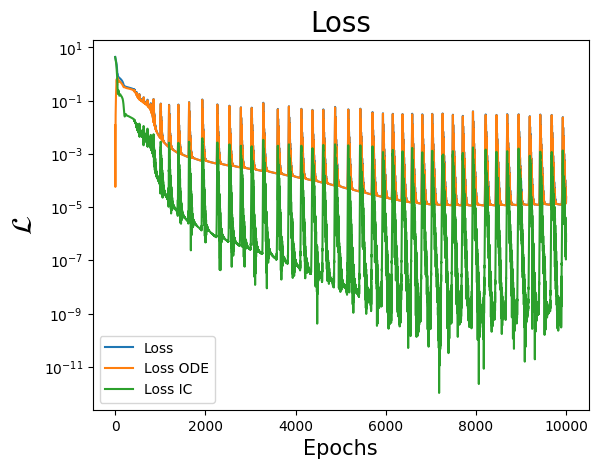

In [6]:
# Grafica Loss
plt.title('Loss', fontsize = 20)
plt.plot(pinn.loss_history['Loss'], label = 'Loss')
plt.plot(pinn.loss_history['Loss ODE'], label = 'Loss ODE')
plt.plot(pinn.loss_history['Loss IC'], label = 'Loss IC')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('$\\mathcal{L}$', fontsize = 20)
plt.legend()
plt.yscale('log')
plt.show()

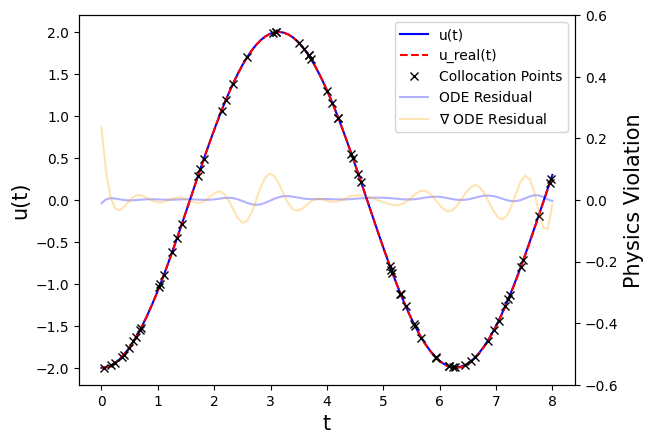

In [7]:
import matplotlib.pyplot as plt

# Definición del rango de t
t_min, t_max = 0, 8
t = torch.linspace(t_min, t_max, 100).reshape(-1,1)
t.requires_grad = True

# Evaluación de las soluciones
u = pinn.forward(t).detach().numpy()
u_real = -2.0 * torch.cos(t).detach().numpy()
res_ode = pinn.loss_ODE(t)[1].detach().numpy()
res_ode_t = pinn.loss_ODE(t)[2].detach().numpy()
u_c = pinn.forward(t_c).detach().numpy()

# Crear el gráfico
fig, ax1 = plt.subplots()

# Graficar u(t) y u_real(t) en el eje de la izquierda
ax1.plot(t.detach().numpy(), u, 'b', label='u(t)')
ax1.plot(t.detach().numpy(), u_real, 'r--', label='u_real(t)')
ax1.set_xlabel('t', fontsize=15)
ax1.set_ylabel('u(t)', fontsize=15)
ax1.tick_params(axis='y')

# Agregar las cruces en los puntos deseados
crosses, = ax1.plot(t_c.detach().numpy(), u_c, 'kx', label='Collocation Points')

# Crear el segundo eje y para las pérdidas residuales
ax2 = ax1.twinx()
ax2.plot(t.detach().numpy(), res_ode, 'b-', label='ODE Residual', alpha=0.3)
ax2.plot(t.detach().numpy(), res_ode_t, 'orange', label='$\\nabla$ ODE Residual', alpha=0.3)
ax2.set_ylabel('Physics Violation', fontsize=15)


# Establecer los rangos del eje y de la derecha
ax2.set_ylim(-0.6, 0.6) 

# Crear una sola leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Mostrar el gráfico
plt.show()


## Experimento 2

El experimento 2 muestra un caso donde la solución propuesta por el enfoque PINNs hace una pobre performance con 32 puntos de colocación distribuidos aleatoreamente, yendo a la solución trivial.

### Dominio experimento 2

In [9]:
# Puntos de Colocación
t_min = 0.0
t_max = 8.0

N_c = 38 # Número de puntos de colocación

t_c = t_min + (t_max - t_min) * torch.rand(N_c,1)
t_c.requires_grad = True

# Puntos Iniciales
t_test_ic = torch.tensor([[0.0]])
t_test_ic.requires_grad = True

### Entrenamiento y Resultados

In [11]:
pinn_2 = PINN_Ex_1()

In [12]:
pinn_2.train(t_c, t_test_ic, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: Loss 5.159029006958008
Epoch 100: Loss 0.5195028185844421
Epoch 200: Loss 0.34008219838142395
Epoch 300: Loss 0.292473703622818
Epoch 400: Loss 0.24348975718021393
Epoch 500: Loss 0.22654090821743011
Epoch 600: Loss 0.17293888330459595
Epoch 700: Loss 0.021742846816778183
Epoch 800: Loss 0.0028139669448137283
Epoch 900: Loss 0.0008309828117489815
Epoch 1000: Loss 0.0011463825358077884
Epoch 1100: Loss 0.00012415896344464272
Epoch 1200: Loss 9.214784950017929e-05
Epoch 1300: Loss 6.951522664166987e-05
Epoch 1400: Loss 7.56517329136841e-05
Epoch 1500: Loss 4.772082684212364e-05
Epoch 1600: Loss 5.3530831792159006e-05
Epoch 1700: Loss 0.006103527266532183
Epoch 1800: Loss 3.407858093851246e-05
Epoch 1900: Loss 0.00019365365733392537
Epoch 2000: Loss 2.88495393760968e-05
Epoch 2100: Loss 0.00011536334932316095
Epoch 2200: Loss 2.7307989512337372e-05
Epoch 2300: Loss 6.362357817124575e-05
Epoch 2400: Loss 2.5193157853209414e-05
Epoch 2500: Loss 8.951158815762028e-05
Epoch 2600: Los

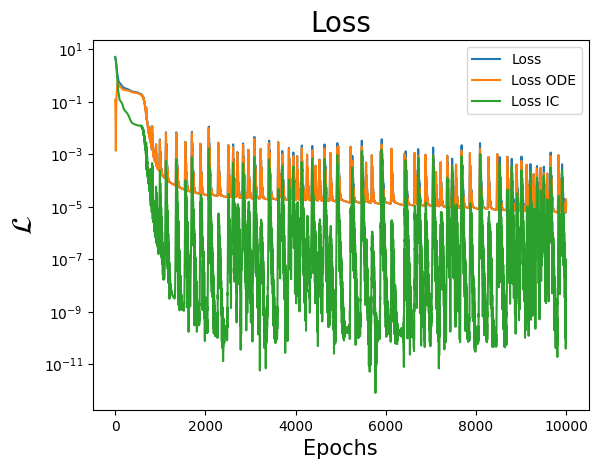

In [13]:
# Grafica Loss
plt.title('Loss', fontsize = 20)
plt.plot(pinn_2.loss_history['Loss'], label = 'Loss')
plt.plot(pinn_2.loss_history['Loss ODE'], label = 'Loss ODE')
plt.plot(pinn_2.loss_history['Loss IC'], label = 'Loss IC')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('$\\mathcal{L}$', fontsize = 20)
plt.legend()
plt.yscale('log')
plt.show()

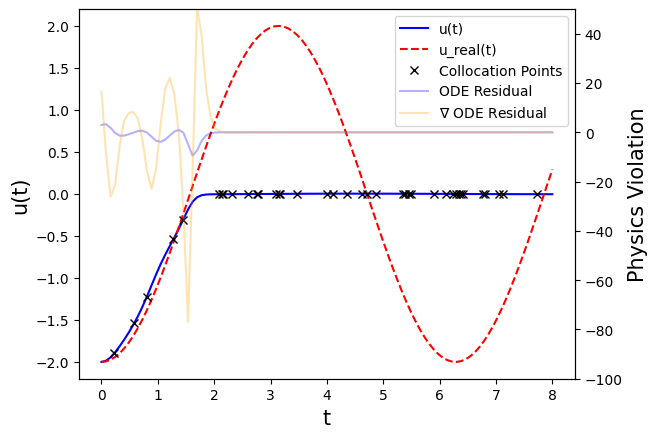

In [15]:
import matplotlib.pyplot as plt

# Definición del rango de t
t_min, t_max = 0, 8
t = torch.linspace(t_min, t_max, 100).reshape(-1,1)
t.requires_grad = True

# Evaluación de las soluciones
u = pinn_2.forward(t).detach().numpy()
u_real = -2.0 * torch.cos(t).detach().numpy()
res_ode = pinn_2.loss_ODE(t)[1].detach().numpy()
res_ode_t = pinn_2.loss_ODE(t)[2].detach().numpy()
u_c = pinn_2.forward(t_c).detach().numpy()

# Crear el gráfico
fig, ax1 = plt.subplots()

# Graficar u(t) y u_real(t) en el eje de la izquierda
ax1.plot(t.detach().numpy(), u, 'b', label='u(t)')
ax1.plot(t.detach().numpy(), u_real, 'r--', label='u_real(t)')
ax1.set_xlabel('t', fontsize=15)
ax1.set_ylabel('u(t)', fontsize=15)
ax1.tick_params(axis='y')

# Agregar las cruces en los puntos deseados
crosses, = ax1.plot(t_c.detach().numpy(), u_c, 'kx', label='Collocation Points')

# Crear el segundo eje y para las pérdidas residuales
ax2 = ax1.twinx()
ax2.plot(t.detach().numpy(), res_ode, 'b-', label='ODE Residual', alpha=0.3)
ax2.plot(t.detach().numpy(), res_ode_t, 'orange', label='$\\nabla$ ODE Residual', alpha=0.3)
ax2.set_ylabel('Physics Violation', fontsize=15)


# Establecer los rangos del eje y de la derecha
ax2.set_ylim(-100, 50) 

# Crear una sola leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Mostrar el gráfico
plt.show()


## Experimento 3

En el siguiente experimento se incorporá un término de penalización en la función de pérdida, sugerido por los autores.

$$\max_{i=1,...,N}\left[ m \dfrac{d^2 u^{NN}(t_i) }{dt^2}+ k\,u^{NN}(t_i)\right]^2$$

In [19]:
class PINN_Ex_2(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 20, num_layers = 6, output_size = 1):
        super(PINN_Ex_2, self).__init__()
        
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            self.hidden_layers.add_module('linear'+str(l), nn.Linear(input_size, hidden_size))
            self.hidden_layers.add_module('tanh'+str(l), nn.Tanh()) 
            input_size = hidden_size
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        self.mse = nn.MSELoss(reduction = 'mean')
        
        self.loss_history = {'Loss': [], 'Loss ODE': [], 'Loss IC': []}

        self.k = 1.5

        self.m = 1.5

    def forward(self, t):
        return self.hidden_layers(t)
    
    def loss_ODE(self, t):
        u = self.forward(t)
        u_t = autograd.grad(u, t, torch.ones_like(u), create_graph = True)[0]
        u_tt = autograd.grad(u_t, t, torch.ones_like(u_t), create_graph = True)[0]
        loss_ode =  self.m * u_tt + self.k * u
        loss_ode_t = autograd.grad(loss_ode, t, torch.ones_like(loss_ode), create_graph = True)[0]
        loss_ode_max = torch.max(loss_ode**2)     # Término nuevo de penalización para el máximo del residual ODE
        return self.mse( self.m * u_tt, - self.k * u ), loss_ode, loss_ode_t, loss_ode_max
    
    def loss_IC(self, t):
        u_0 = self.forward(t)
        u_t_0 = autograd.grad(u_0, t, torch.ones_like(u_0), create_graph = True)[0]
        loss_ic_u_0 = self.mse(self.forward(t), -2.0 * torch.ones_like(t))
        loss_ic_u_t_0 = self.mse(u_t_0, 0.0 * torch.ones_like(t))
        return loss_ic_u_0 + loss_ic_u_t_0
    
    def loss(self, t, t_ic):
        return self.loss_ODE(t)[0] + self.loss_IC(t_ic) + self.loss_ODE(t)[3]
    
    def train(self, t, t_ic, epochs = 10000, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start_time = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = self.loss(t, t_ic)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            self.loss_history['Loss ODE'].append(self.loss_ODE(t)[0].item())
            self.loss_history['Loss IC'].append(self.loss_IC(t_ic).item())
            if epoch % 100 == 0:
                print('Epoch {}: Loss {}'.format(epoch, loss.item()))
        print('Training time: ', time.time() - start_time)      

### Dominio Experimento 3

In [ ]:
# Puntos de Colocación
t_min = 0.0
t_max = 8.0

N_c = 38 # Número de puntos de colocación

t_c = t_min + (t_max - t_min) * torch.rand(N_c,1)
t_c.requires_grad = True

# Puntos Iniciales
t_test_ic = torch.tensor([[0.0]])
t_test_ic.requires_grad = True

### Entrenamiento y Resultados

In [20]:
pinn_3 = PINN_Ex_2()

In [21]:
pinn_3.train(t_c, t_test_ic, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: Loss 4.330617904663086
Epoch 100: Loss 1.7473281621932983
Epoch 200: Loss 0.9063971042633057
Epoch 300: Loss 0.844321608543396
Epoch 400: Loss 0.8199195861816406
Epoch 500: Loss 0.772029459476471
Epoch 600: Loss 0.8103163242340088
Epoch 700: Loss 0.7615123987197876
Epoch 800: Loss 0.7564256191253662
Epoch 900: Loss 0.7618656158447266
Epoch 1000: Loss 0.7704287767410278
Epoch 1100: Loss 0.7650665640830994
Epoch 1200: Loss 0.759734034538269
Epoch 1300: Loss 0.7319303154945374
Epoch 1400: Loss 0.7419373989105225
Epoch 1500: Loss 0.7689151167869568
Epoch 1600: Loss 0.7426557540893555
Epoch 1700: Loss 0.7401329278945923
Epoch 1800: Loss 0.7563703060150146
Epoch 1900: Loss 0.7164105772972107
Epoch 2000: Loss 0.7581037282943726
Epoch 2100: Loss 0.7578993439674377
Epoch 2200: Loss 0.7265574932098389
Epoch 2300: Loss 0.7098132371902466
Epoch 2400: Loss 0.7218829393386841
Epoch 2500: Loss 0.7285779714584351
Epoch 2600: Loss 0.6992813348770142
Epoch 2700: Loss 0.7229865789413452
Epoch 28

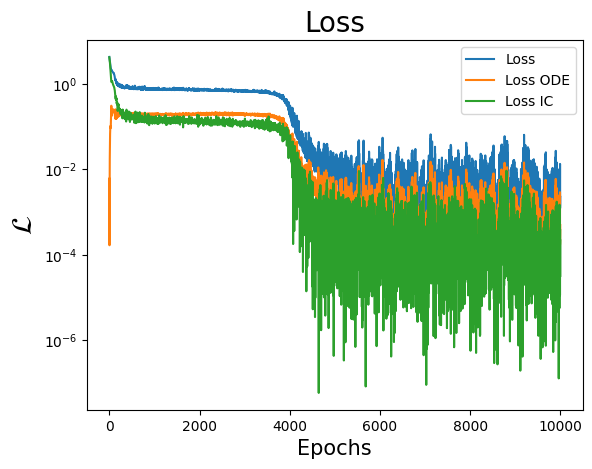

In [22]:
# Grafica Loss
plt.title('Loss', fontsize = 20)
plt.plot(pinn_3.loss_history['Loss'], label = 'Loss')
plt.plot(pinn_3.loss_history['Loss ODE'], label = 'Loss ODE')
plt.plot(pinn_3.loss_history['Loss IC'], label = 'Loss IC')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('$\\mathcal{L}$', fontsize = 20)
plt.legend()
plt.yscale('log')
plt.show()

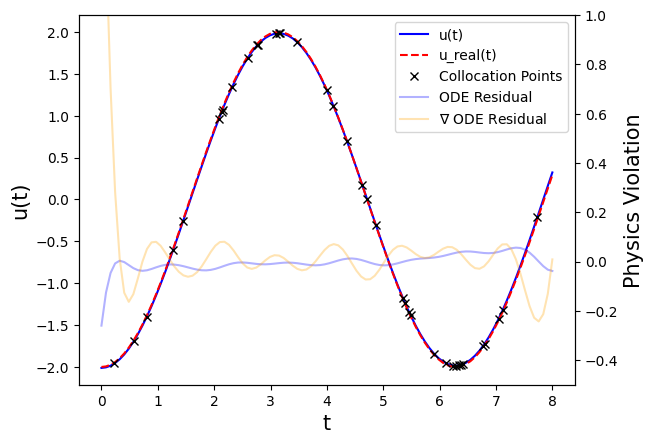

In [24]:
import matplotlib.pyplot as plt

# Definición del rango de t
t_min, t_max = 0, 8
t = torch.linspace(t_min, t_max, 100).reshape(-1,1)
t.requires_grad = True

# Evaluación de las soluciones
u = pinn_3.forward(t).detach().numpy()
u_real = -2.0 * torch.cos(t).detach().numpy()
res_ode = pinn_3.loss_ODE(t)[1].detach().numpy()
res_ode_t = pinn_3.loss_ODE(t)[2].detach().numpy()
u_c = pinn_3.forward(t_c).detach().numpy()

# Crear el gráfico
fig, ax1 = plt.subplots()

# Graficar u(t) y u_real(t) en el eje de la izquierda
ax1.plot(t.detach().numpy(), u, 'b', label='u(t)')
ax1.plot(t.detach().numpy(), u_real, 'r--', label='u_real(t)')
ax1.set_xlabel('t', fontsize=15)
ax1.set_ylabel('u(t)', fontsize=15)
ax1.tick_params(axis='y')

# Agregar las cruces en los puntos deseados
crosses, = ax1.plot(t_c.detach().numpy(), u_c, 'kx', label='Collocation Points')

# Crear el segundo eje y para las pérdidas residuales
ax2 = ax1.twinx()
ax2.plot(t.detach().numpy(), res_ode, 'b-', label='ODE Residual', alpha=0.3)
ax2.plot(t.detach().numpy(), res_ode_t, 'orange', label='$\\nabla$ ODE Residual', alpha=0.3)
ax2.set_ylabel('Physics Violation', fontsize=15)


# Establecer los rangos del eje y de la derecha
ax2.set_ylim(-0.5, 1) 

# Crear una sola leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Mostrar el gráfico
plt.show()

## Experimento 4

El último eperimento propone 16 puntos de colocación equiespaciados. Lo anterior permiete, según lo autores, alcanzar un performance similar al expermiento 3. 

### Dominio experimento 4

In [32]:
# Puntos de Colocación
t_min = 0.0
t_max = 8.0

N_c = 16 # Número de puntos de colocación

t_c = torch.linspace(t_min, t_max, N_c).reshape(-1,1)
t_c.requires_grad = True

# Puntos Iniciales
t_test_ic = torch.tensor([[0.0]])
t_test_ic.requires_grad = True

### Entrenamiento y resultados

In [33]:
pinn_4 = PINN_Ex_2()

In [34]:
pinn_4.train(t_c, t_test_ic, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: Loss 3.6042866706848145
Epoch 100: Loss 2.0198874473571777
Epoch 200: Loss 1.3160607814788818
Epoch 300: Loss 0.8225270509719849
Epoch 400: Loss 0.88261878490448
Epoch 500: Loss 0.807403028011322
Epoch 600: Loss 0.8059553503990173
Epoch 700: Loss 0.8275285959243774
Epoch 800: Loss 0.7880585193634033
Epoch 900: Loss 0.790229082107544
Epoch 1000: Loss 0.7599881887435913
Epoch 1100: Loss 0.80899977684021
Epoch 1200: Loss 0.7651885747909546
Epoch 1300: Loss 0.7570419311523438
Epoch 1400: Loss 0.7325952053070068
Epoch 1500: Loss 0.7250438928604126
Epoch 1600: Loss 0.7059763669967651
Epoch 1700: Loss 0.7431726455688477
Epoch 1800: Loss 0.6927971243858337
Epoch 1900: Loss 0.7070717811584473
Epoch 2000: Loss 0.6654444932937622
Epoch 2100: Loss 0.6832211017608643
Epoch 2200: Loss 0.6243674159049988
Epoch 2300: Loss 0.6246633529663086
Epoch 2400: Loss 0.628903865814209
Epoch 2500: Loss 0.6669231653213501
Epoch 2600: Loss 0.5849928855895996
Epoch 2700: Loss 0.36132991313934326
Epoch 2800

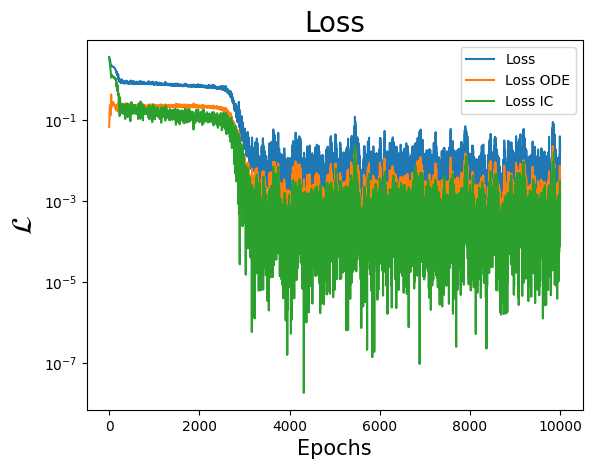

In [35]:
# Grafica Loss
plt.title('Loss', fontsize = 20)
plt.plot(pinn_4.loss_history['Loss'], label = 'Loss')
plt.plot(pinn_4.loss_history['Loss ODE'], label = 'Loss ODE')
plt.plot(pinn_4.loss_history['Loss IC'], label = 'Loss IC')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('$\\mathcal{L}$', fontsize = 20)
plt.legend()
plt.yscale('log')
plt.show()

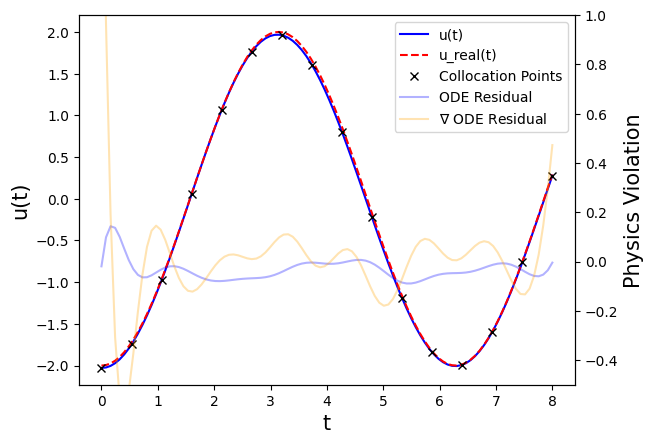

In [36]:
import matplotlib.pyplot as plt

# Definición del rango de t
t_min, t_max = 0, 8
t = torch.linspace(t_min, t_max, 100).reshape(-1,1)
t.requires_grad = True

# Evaluación de las soluciones
u = pinn_4.forward(t).detach().numpy()
u_real = -2.0 * torch.cos(t).detach().numpy()
res_ode = pinn_4.loss_ODE(t)[1].detach().numpy()
res_ode_t = pinn_4.loss_ODE(t)[2].detach().numpy()
u_c = pinn_4.forward(t_c).detach().numpy()

# Crear el gráfico
fig, ax1 = plt.subplots()

# Graficar u(t) y u_real(t) en el eje de la izquierda
ax1.plot(t.detach().numpy(), u, 'b', label='u(t)')
ax1.plot(t.detach().numpy(), u_real, 'r--', label='u_real(t)')
ax1.set_xlabel('t', fontsize=15)
ax1.set_ylabel('u(t)', fontsize=15)
ax1.tick_params(axis='y')

# Agregar las cruces en los puntos deseados
crosses, = ax1.plot(t_c.detach().numpy(), u_c, 'kx', label='Collocation Points')

# Crear el segundo eje y para las pérdidas residuales
ax2 = ax1.twinx()
ax2.plot(t.detach().numpy(), res_ode, 'b-', label='ODE Residual', alpha=0.3)
ax2.plot(t.detach().numpy(), res_ode_t, 'orange', label='$\\nabla$ ODE Residual', alpha=0.3)
ax2.set_ylabel('Physics Violation', fontsize=15)


# Establecer los rangos del eje y de la derecha
ax2.set_ylim(-0.5, 1) 

# Crear una sola leyenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Mostrar el gráfico
plt.show()